# Winter data for Upper Slope 75 kHz ADCP
**Full depth tidal filters from January 1 - February 28, 2018**

## Imports

In [2]:
import qgrid
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import scipy.interpolate as interp
import pandas as pd
%matplotlib notebook

In [3]:
# Upper Slope January and February

with xr.open_dataset('../Nov11/UpperSlopeJanFeb2018.nc') as ds:
    print(ds)

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 1, longitude: 1, time: 1404)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01T00:30:00.000003328 ... 2018-02-28T11:29:59.999996672
  * depth      (depth) float32 378.27 370.27 362.27 354.27 ... 2.27 -5.73 -13.73
  * latitude   (latitude) float32 48.42743
  * longitude  (longitude) float32 -126.17467
Data variables:
    u          (time, depth) float32 ...
    v          (time, depth) float32 ...
    w          (time, depth) float32 ...
    temp       (time) float32 ...
Attributes:
    Conventions:                             CF-1.6
    title:                                   Ocean Networks Canada RDI ADCP Data
    institution:                             Ocean Networks Canada
    source:                                  Fixed-position Teledyne-RDI ADCP...
    history:                                 data extracted from raw output, ...
    references:                              http://www.oceannetworks.ca/
    CREATION

In [ ]:
grid = pd.DataFrame(uorig)
qgrid.show_grid(grid, show_toolbar=True)

## Depth

**Find specific depth to remove depth values (unreliable data, from visual inspection of initial plots), about 100m at the top**

In [50]:
# find specific depth to remove depth values (unreliable data, from visual inspection of initial plots)
# about 100m at the top
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx     # returns index of nearest value

array = ds.depth
upval = 100        # meters
upidx = find_nearest(array, upval)

print("Index at cutoff:", find_nearest(array, upval))
print("Value at cutoff:", abs(array[find_nearest(array, upval)]))

depth = np.array(ds.depth[0:upidx+1])       # remove unwanted upper depths

print("Length of new array: ", len(depth))
print(depth[6])
print(depth[30])

Index at cutoff: 35
Value at cutoff: <xarray.DataArray 'depth' ()>
array(98.27, dtype=float32)
Coordinates:
    depth    float32 98.27
Length of new array:  36
330.27
138.27


## Filter

**Low pass Butterworth filter for 60 hours to remove tides**

In [5]:
# low pass Butterworth filter for 60 hours to remove tides

fs = 1                # 1 sample per HOUR for entire time series
fc = 0.0167           # 60 hour low pass filter
Wn = fc / (fs / 2)    # normalised cut-off frequencies
b, a = sig.butter(10, Wn, 'lowpass')  # digital butterworth filter
w, h = sig.freqz(b, a)

<IPython.core.display.Javascript object>


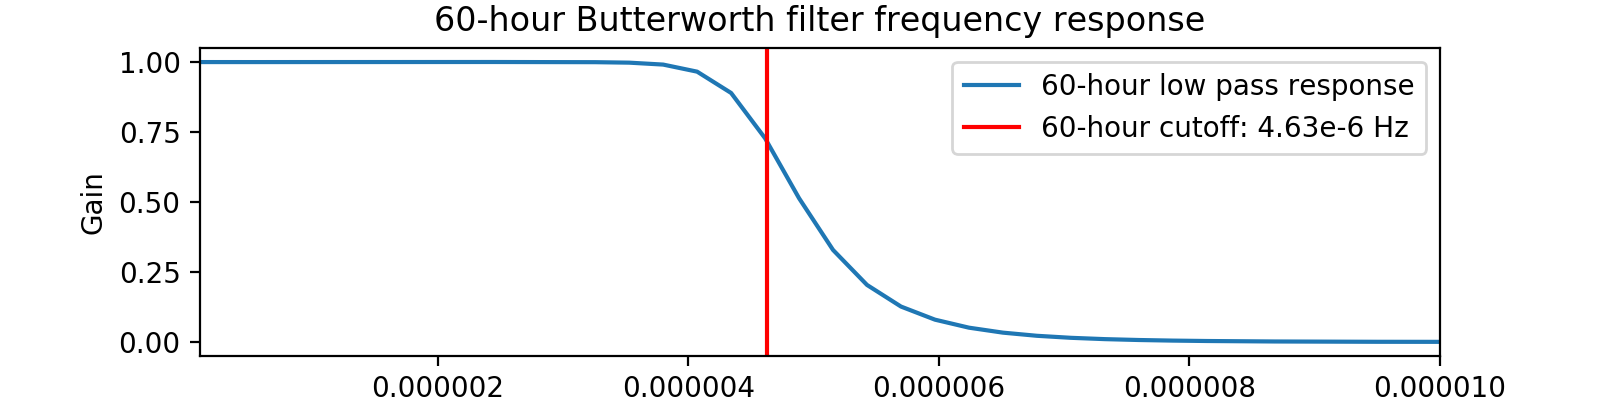

In [6]:
plt.figure(figsize=(8,2))                      # check filter response
plt.plot((1/(2*np.pi))*w / 3600, abs(h), label = "60-hour low pass response") # response in Hz
plt.xlim(1e-7, 1e-5)
plt.axvline(4.63e-6, color ='red', label = "60-hour cutoff: 4.63e-6 Hz")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Gain")
plt.title("60-hour Butterworth filter frequency response")
plt.legend(loc='best')
plt.show()

**Loop to acquire original, filtered, and residual data**

In [7]:
# loop to filter tides from all depths

t = len(ds.time)               # number of time data points
d = len(depth)                 # number of depth data points after removing upper portion
days = t/24                    # number of days
time = np.linspace(0,days,t)   # x-range

In [8]:
uorig = np.empty([t,d])        # empty array for original u data
vorig = np.empty([t,d])        # empty array for original v data
worig = np.empty([t,d])        # empty array for original w data

ulp = np.empty([t,d])          # empty array for low-pass filtered u values
vlp = np.empty([t,d])          # empty array for low-pass filtered v values
wlp = np.empty([t,d])          # empty array for low-pass filtered w values

for j in range(d):
    utemp = pd.Series(ds.u[:,j])
    uint = utemp.interpolate(method="cubic")
    uorig[:,j] = uint                    # set interpolated data to original array
    ulp[:,j] = sig.filtfilt(b, a, uint)  # set low pass array values
    
    vtemp = pd.Series(ds.v[:,j])
    vint = vtemp.interpolate(method="cubic")
    vorig[:,j] = vint                    # set interpolated data to original array
    vlp[:,j] = sig.filtfilt(b, a, vint)  # set low pass array values
    
    wtemp = pd.Series(ds.w[:,j])
    wint = wtemp.interpolate(method="cubic")
    worig[:,j] = wint                    # set interpolated data to original array
    wlp[:,j] = sig.filtfilt(b, a, wint)  # set low pass array values
    
uhp = uorig - ulp
vhp = vorig - vlp
whp = worig - wlp

## Spectra ##

In [64]:
um6 = uorig[:,6] - np.mean(uorig[:,6]) # depth[6] = ~330 meters
ulpm6 = ulp[:,6] - np.mean(ulp[:,6])
uhpm6 = uhp[:,6] - np.mean(uhp[:,6])

vm6 = vorig[:,6] - np.mean(vorig[:,6])
vlpm6 = vlp[:,6] - np.mean(vlp[:,6])
vhpm6 = vhp[:,6] - np.mean(vhp[:,6])

wm6 = worig[:,6] - np.mean(worig[:,6])
wlpm6 = wlp[:,6] - np.mean(wlp[:,6])
whpm6 = whp[:,6] - np.mean(whp[:,6])

In [65]:
#typically use 2**x for nperseg, up to sample size

um6_f, um6_PDS = sig.welch(um6, fs=1, window='hann', nperseg=1404, return_onesided=True)
ulpm6_f, ulpm6_PDS = sig.welch(ulpm6, fs=1, window='hann', nperseg=1404, return_onesided=True)
uhpm6_f, uhpm6_PDS = sig.welch(uhpm6, fs=1, window='hann', nperseg=1404, return_onesided=True)

vm6_f, vm6_PDS = sig.welch(vm6, fs=1, window='hann', nperseg=1404, return_onesided=True)
vlpm6_f, vlpm6_PDS = sig.welch(vlpm6, fs=1, window='hann', nperseg=1404, return_onesided=True)
vhpm6_f, vhpm6_PDS = sig.welch(vhpm6, fs=1, window='hann', nperseg=1404, return_onesided=True)

wm6_f, wm6_PDS = sig.welch(wm6, fs=1, window='hann', nperseg=1404, return_onesided=True)
wlpm6_f, wlpm6_PDS = sig.welch(wlpm6, fs=1, window='hann', nperseg=1404, return_onesided=True)
whpm6_f, whpm6_PDS = sig.welch(whpm6, fs=1, window='hann', nperseg=1404, return_onesided=True)

<IPython.core.display.Javascript object>


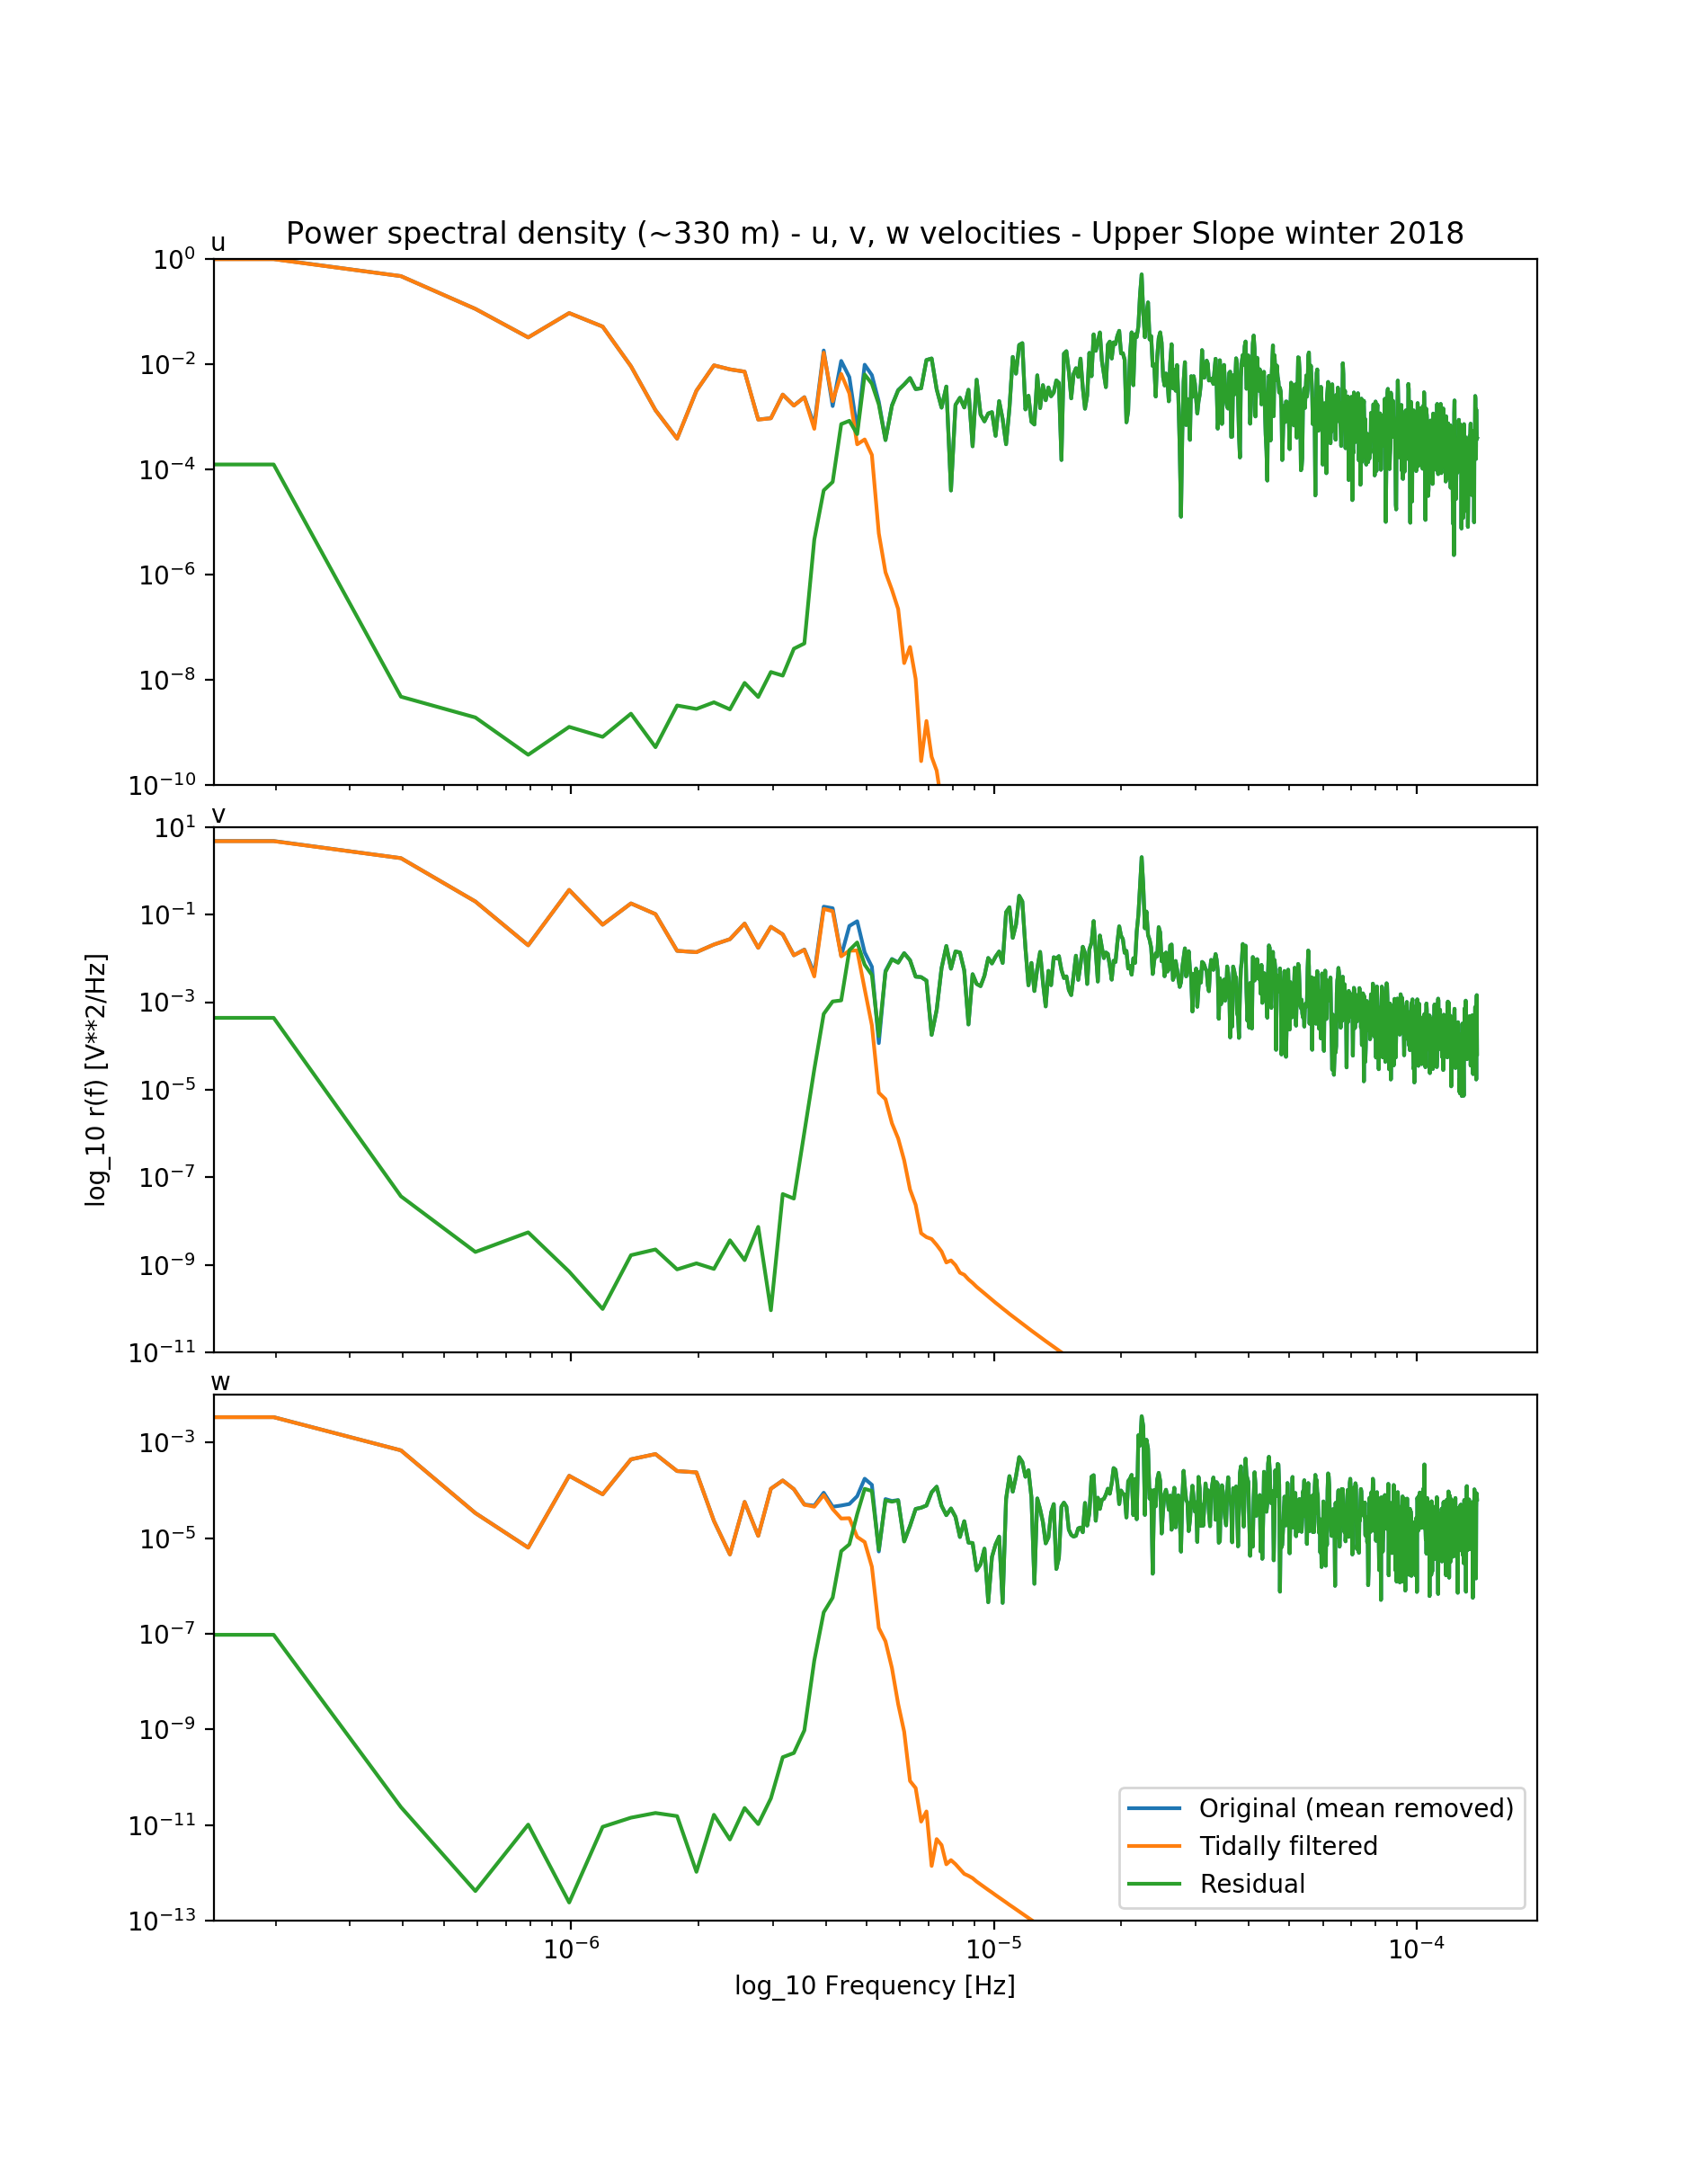

In [66]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9.5,12), sharex=True)
fig.subplots_adjust(hspace = 0.08)

ax1.loglog(um6_f/3600, um6_PDS, label='Original (mean removed)')
ax1.loglog(ulpm6_f/3600, ulpm6_PDS, label='Tidally filtered')
ax1.loglog(uhpm6_f/3600, uhpm6_PDS, label='Residual')
ax1.set_ylim(10e-11,10e-1)
ax1.set_title('Power spectral density (~330 m) - u, v, w velocities - Upper Slope winter 2018')

ax2.loglog(vm6_f/3600, vm6_PDS, label='Original (mean removed)')
ax2.loglog(vlpm6_f/3600, vlpm6_PDS, label='Tidally filtered')
ax2.loglog(vhpm6_f/3600, vhpm6_PDS, label='Residual')
ax2.set_ylim(10e-12,10e0)

ax3.loglog(wm6_f/3600, wm6_PDS, label='Original (mean removed)')
ax3.loglog(wlpm6_f/3600, wlpm6_PDS, label='Tidally filtered')
ax3.loglog(whpm6_f/3600, whpm6_PDS, label='Residual')
ax3.set_ylim(10e-14,10e-3)
ax3.set_xlabel('log_10 Frequency [Hz]')

fig.text(0.05, 0.5, 'log_10 r(f) [V**2/Hz]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'u', va='center')
fig.text(0.123, 0.622, 'v', va='center')
fig.text(0.123, 0.359, 'w', va='center')

plt.legend()
plt.show()

In [73]:
um30 = uorig[:,30] - np.mean(uorig[:,30]) # depth[30] = ~140 meters
ulpm30 = ulp[:,30] - np.mean(ulp[:,30])
uhpm30 = uhp[:,30] - np.mean(uhp[:,30])

vm30 = vorig[:,30] - np.mean(vorig[:,30])
vlpm30 = vlp[:,30] - np.mean(vlp[:,30])
vhpm30 = vhp[:,30] - np.mean(vhp[:,30])

wm30 = worig[:,30] - np.mean(worig[:,30])
wlpm30 = wlp[:,30] - np.mean(wlp[:,30])
whpm30 = whp[:,30] - np.mean(whp[:,30])

In [74]:
#typically use 2**x for nperseg, up to sample size

um30_f, um30_PDS = sig.welch(um30, fs=1, window='hann', nperseg=1404, return_onesided=True)
ulpm30_f, ulpm30_PDS = sig.welch(ulpm30, fs=1, window='hann', nperseg=1404, return_onesided=True)
uhpm30_f, uhpm30_PDS = sig.welch(uhpm30, fs=1, window='hann', nperseg=1404, return_onesided=True)

vm30_f, vm30_PDS = sig.welch(vm30, fs=1, window='hann', nperseg=1404, return_onesided=True)
vlpm30_f, vlpm30_PDS = sig.welch(vlpm30, fs=1, window='hann', nperseg=1404, return_onesided=True)
vhpm30_f, vhpm30_PDS = sig.welch(vhpm30, fs=1, window='hann', nperseg=1404, return_onesided=True)

wm30_f, wm30_PDS = sig.welch(wm30, fs=1, window='hann', nperseg=1404, return_onesided=True)
wlpm30_f, wlpm30_PDS = sig.welch(wlpm30, fs=1, window='hann', nperseg=1404, return_onesided=True)
whpm30_f, whpm30_PDS = sig.welch(whpm30, fs=1, window='hann', nperseg=1404, return_onesided=True)

<IPython.core.display.Javascript object>


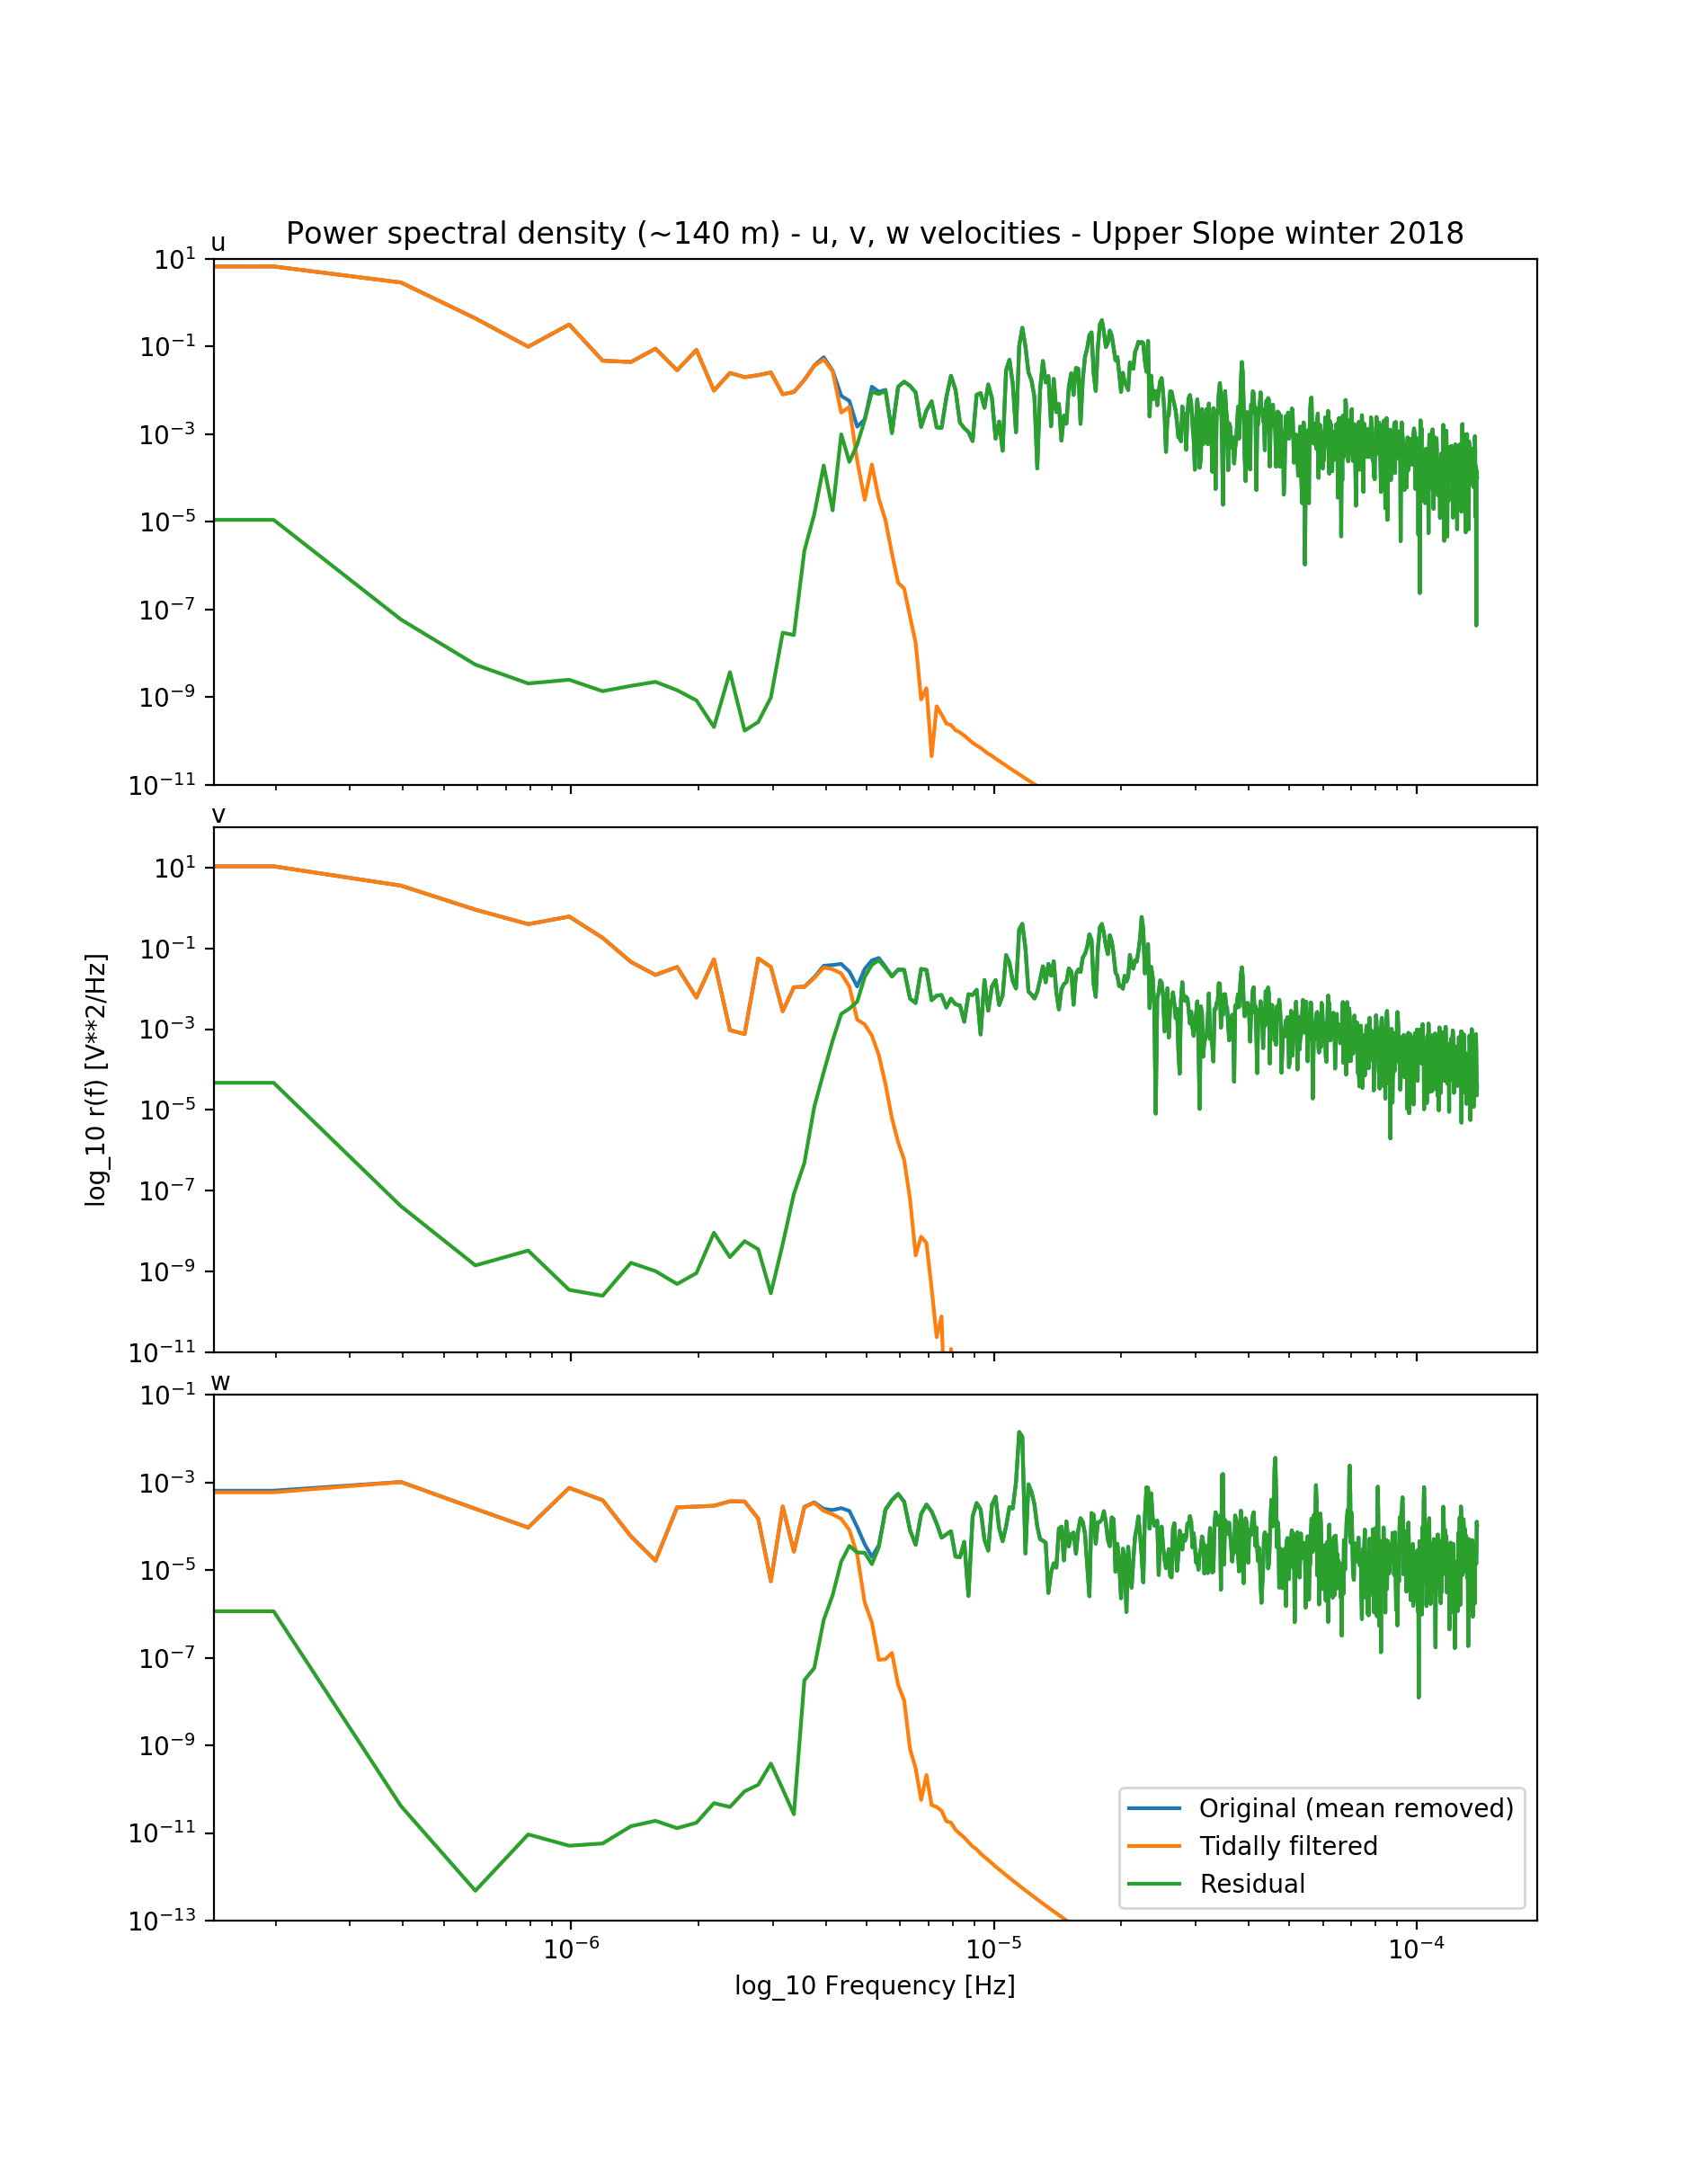

In [77]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9.5,12), sharex=True)
fig.subplots_adjust(hspace = 0.08)

ax1.loglog(um30_f/3600, um30_PDS, label='Original (mean removed)')
ax1.loglog(ulpm30_f/3600, ulpm30_PDS, label='Tidally filtered')
ax1.loglog(uhpm30_f/3600, uhpm30_PDS, label='Residual')
ax1.set_ylim(10e-12,10e0)
ax1.set_title('Power spectral density (~140 m) - u, v, w velocities - Upper Slope winter 2018')

ax2.loglog(vm30_f/3600, vm30_PDS, label='Original (mean removed)')
ax2.loglog(vlpm30_f/3600, vlpm30_PDS, label='Tidally filtered')
ax2.loglog(vhpm30_f/3600, vhpm30_PDS, label='Residual')
ax2.set_ylim(10e-12,10e1)

ax3.loglog(wm30_f/3600, wm30_PDS, label='Original (mean removed)')
ax3.loglog(wlpm30_f/3600, wlpm30_PDS, label='Tidally filtered')
ax3.loglog(whpm30_f/3600, whpm30_PDS, label='Residual')
ax3.set_ylim(10e-14,10e-2)
ax3.set_xlabel('log_10 Frequency [Hz]')

fig.text(0.05, 0.5, 'log_10 r(f) [V**2/Hz]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'u', va='center')
fig.text(0.123, 0.622, 'v', va='center')
fig.text(0.123, 0.359, 'w', va='center')

plt.legend()
plt.show()

## Plots

**Plots for u, v, w (original, filtered, and residual) data**

<IPython.core.display.Javascript object>


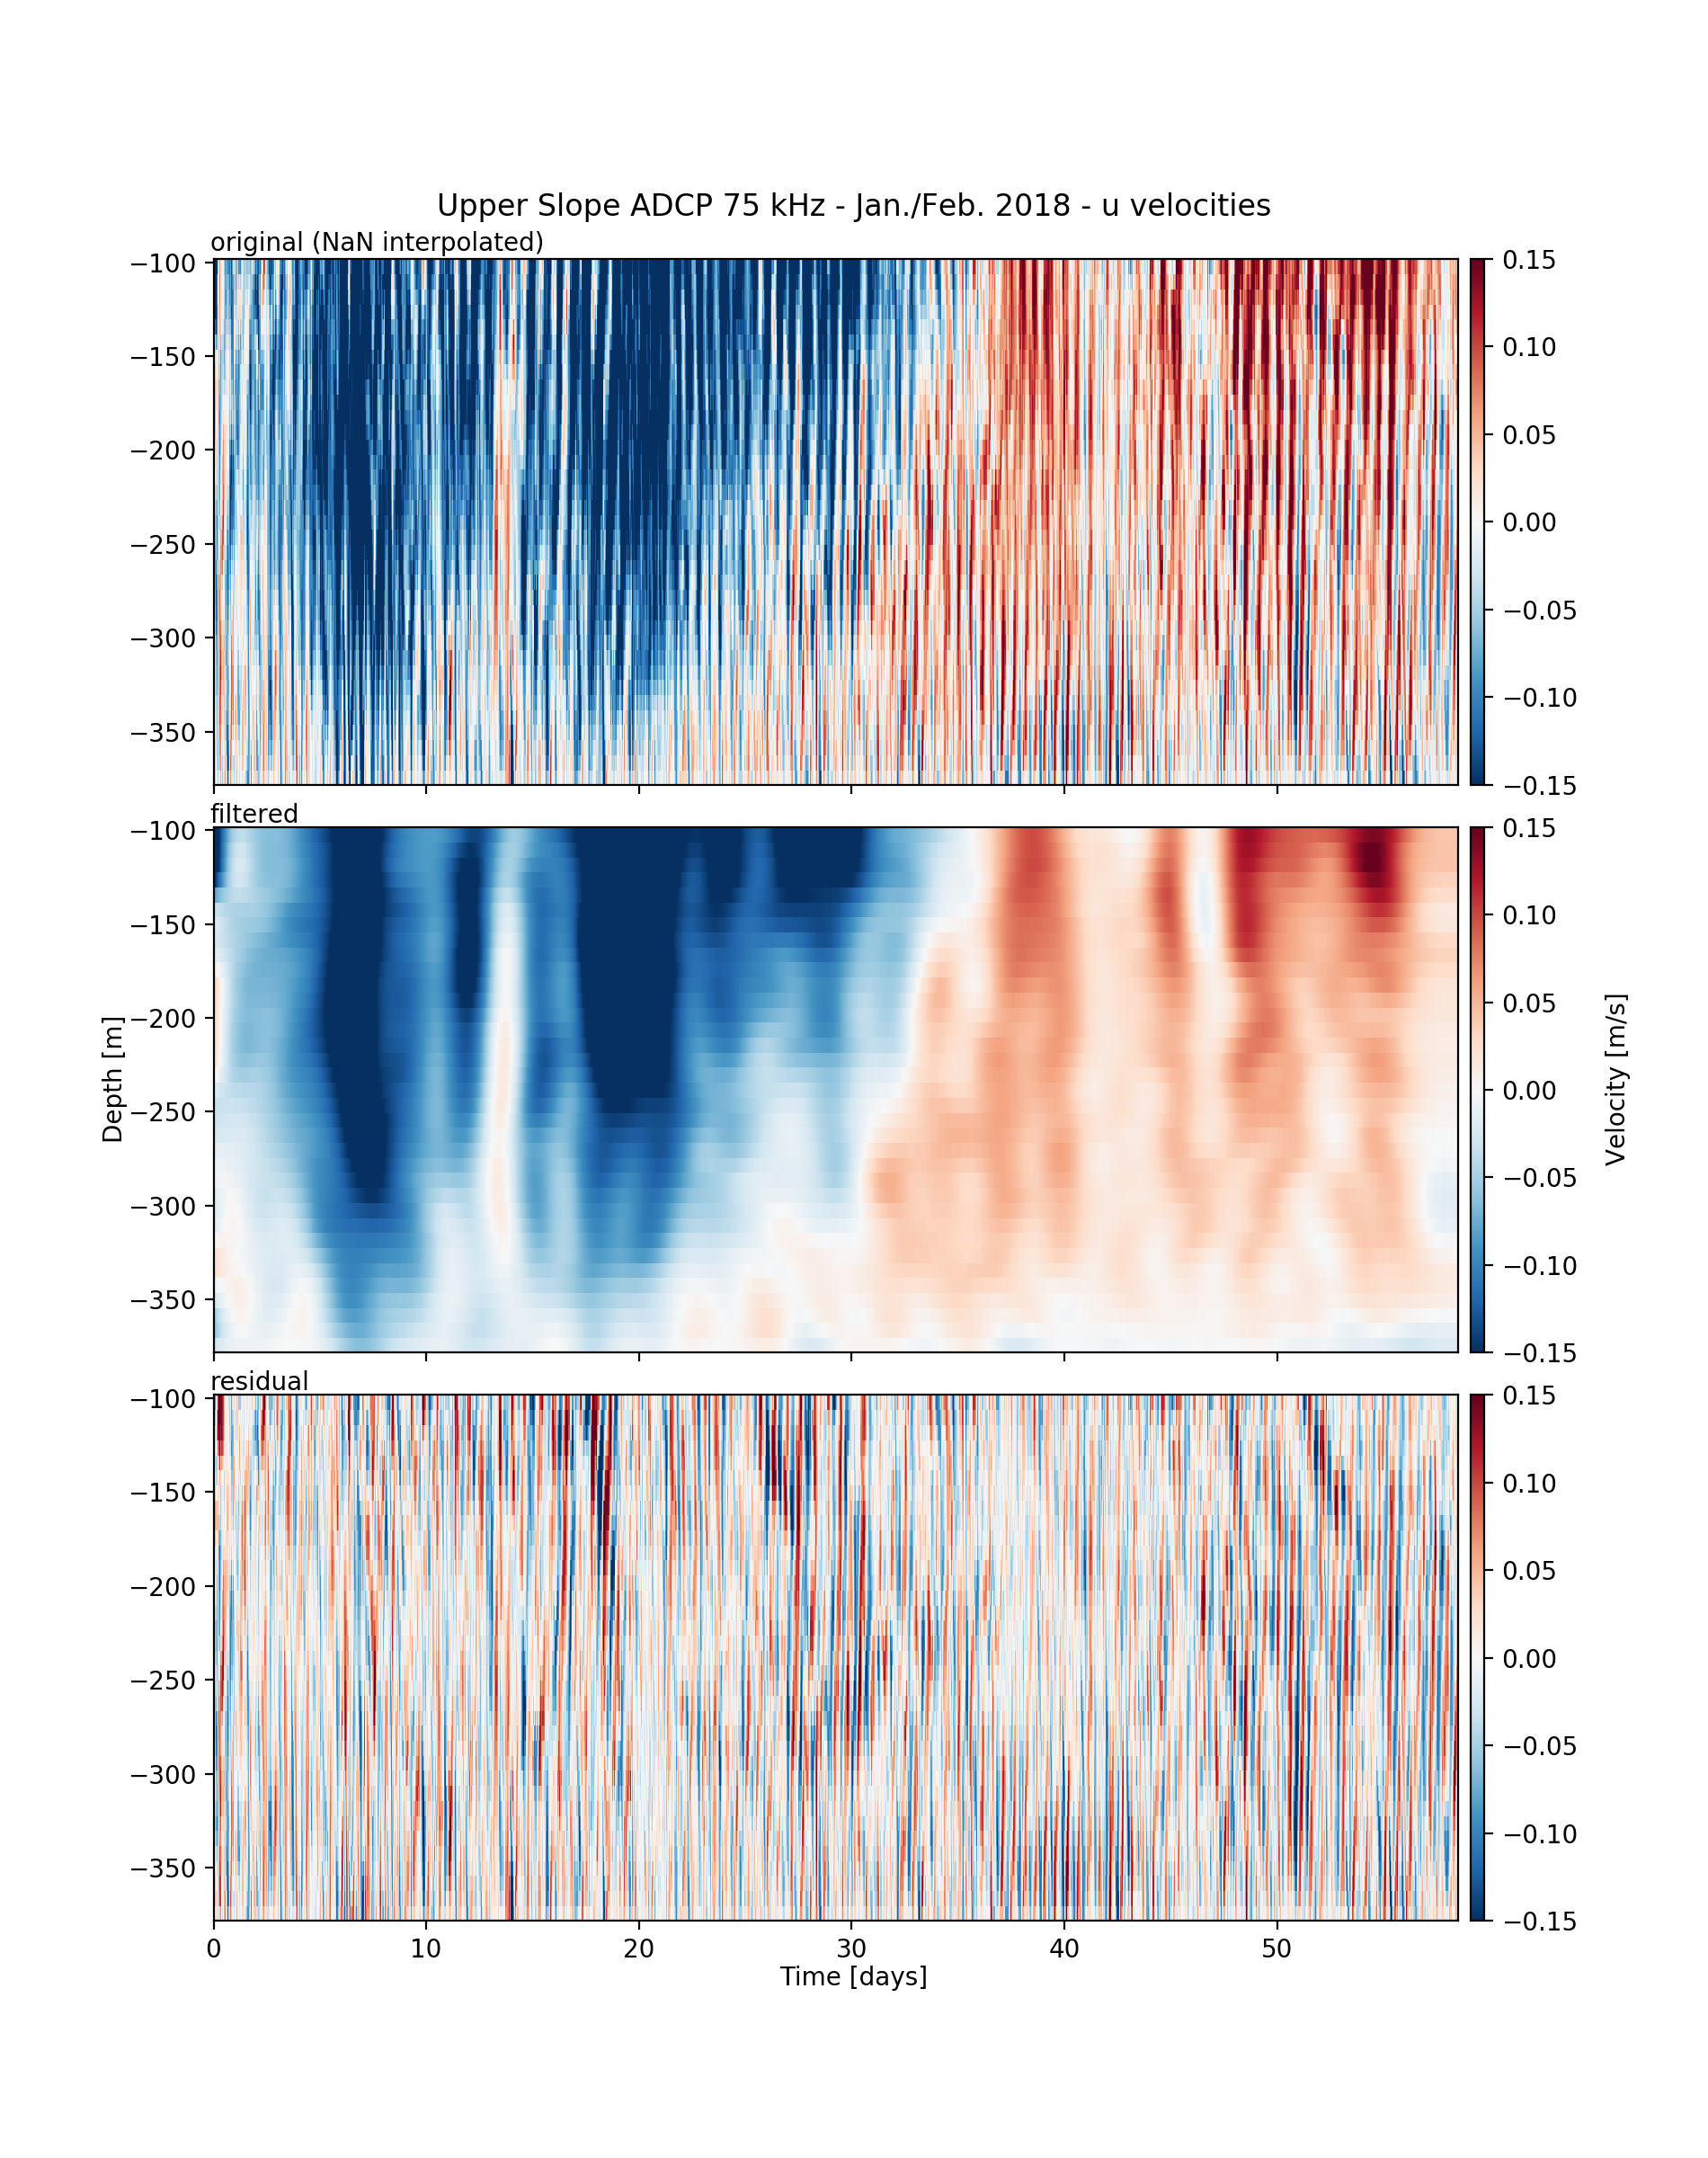

In [9]:
# plot u data

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.08)
fig.text(0.5, 0.9, 'Upper Slope ADCP 75 kHz - Jan./Feb. 2018 - u velocities', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'original (NaN interpolated)', va='center')
fig.text(0.123, 0.622, 'filtered', va='center')
fig.text(0.123, 0.359, 'residual', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.08, 'Time [days]', ha='center')

im1 = ax1.pcolormesh(time, -depth, uorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.15, vmax=0.15)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40)

im2 = ax2.pcolormesh(time, -depth, ulp.T, rasterized=True, cmap='RdBu_r', vmin=-0.15, vmax=0.15)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=40)

im3 = ax3.pcolormesh(time, -depth, uhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.15, vmax=0.15)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40)

XXX

<IPython.core.display.Javascript object>


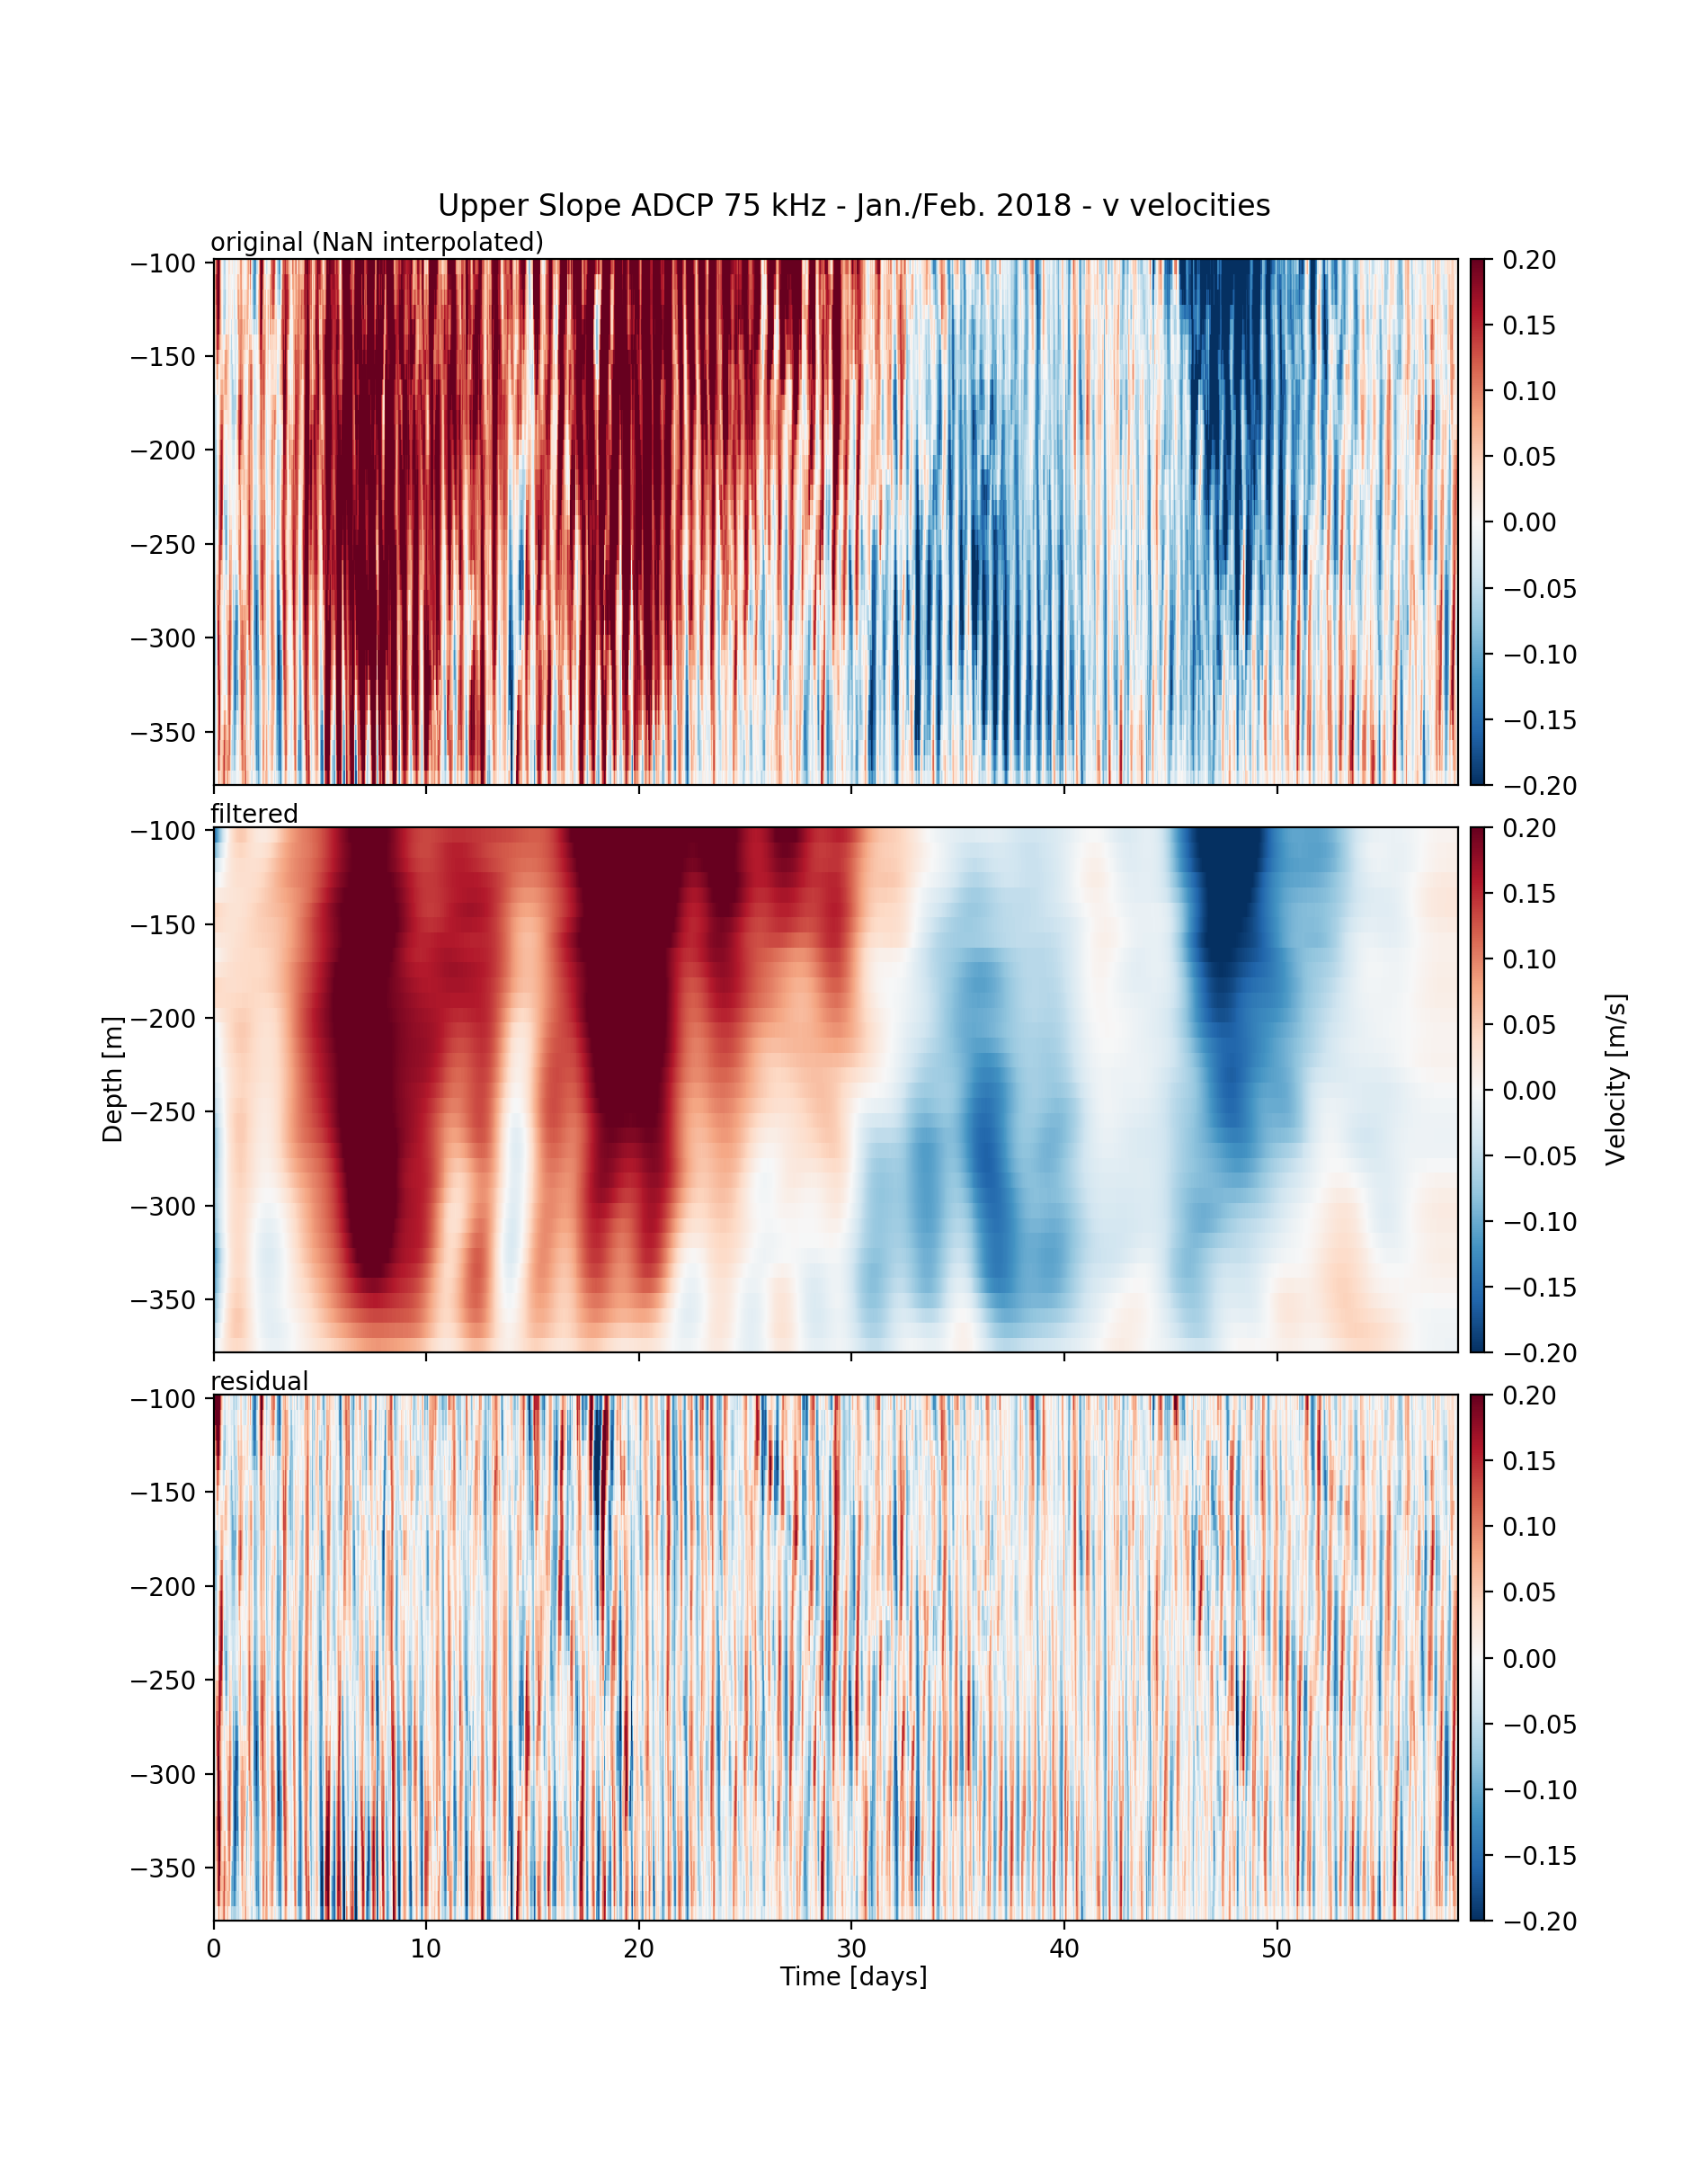

In [10]:
# plot v data

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.08)
fig.text(0.5, 0.9, 'Upper Slope ADCP 75 kHz - Jan./Feb. 2018 - v velocities', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'original (NaN interpolated)', va='center')
fig.text(0.123, 0.622, 'filtered', va='center')
fig.text(0.123, 0.359, 'residual', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.08, 'Time [days]', ha='center')

im1 = ax1.pcolormesh(time, -depth, vorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40)

im2 = ax2.pcolormesh(time, -depth, vlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=40)

im3 = ax3.pcolormesh(time, -depth, vhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40)

XXX

<IPython.core.display.Javascript object>


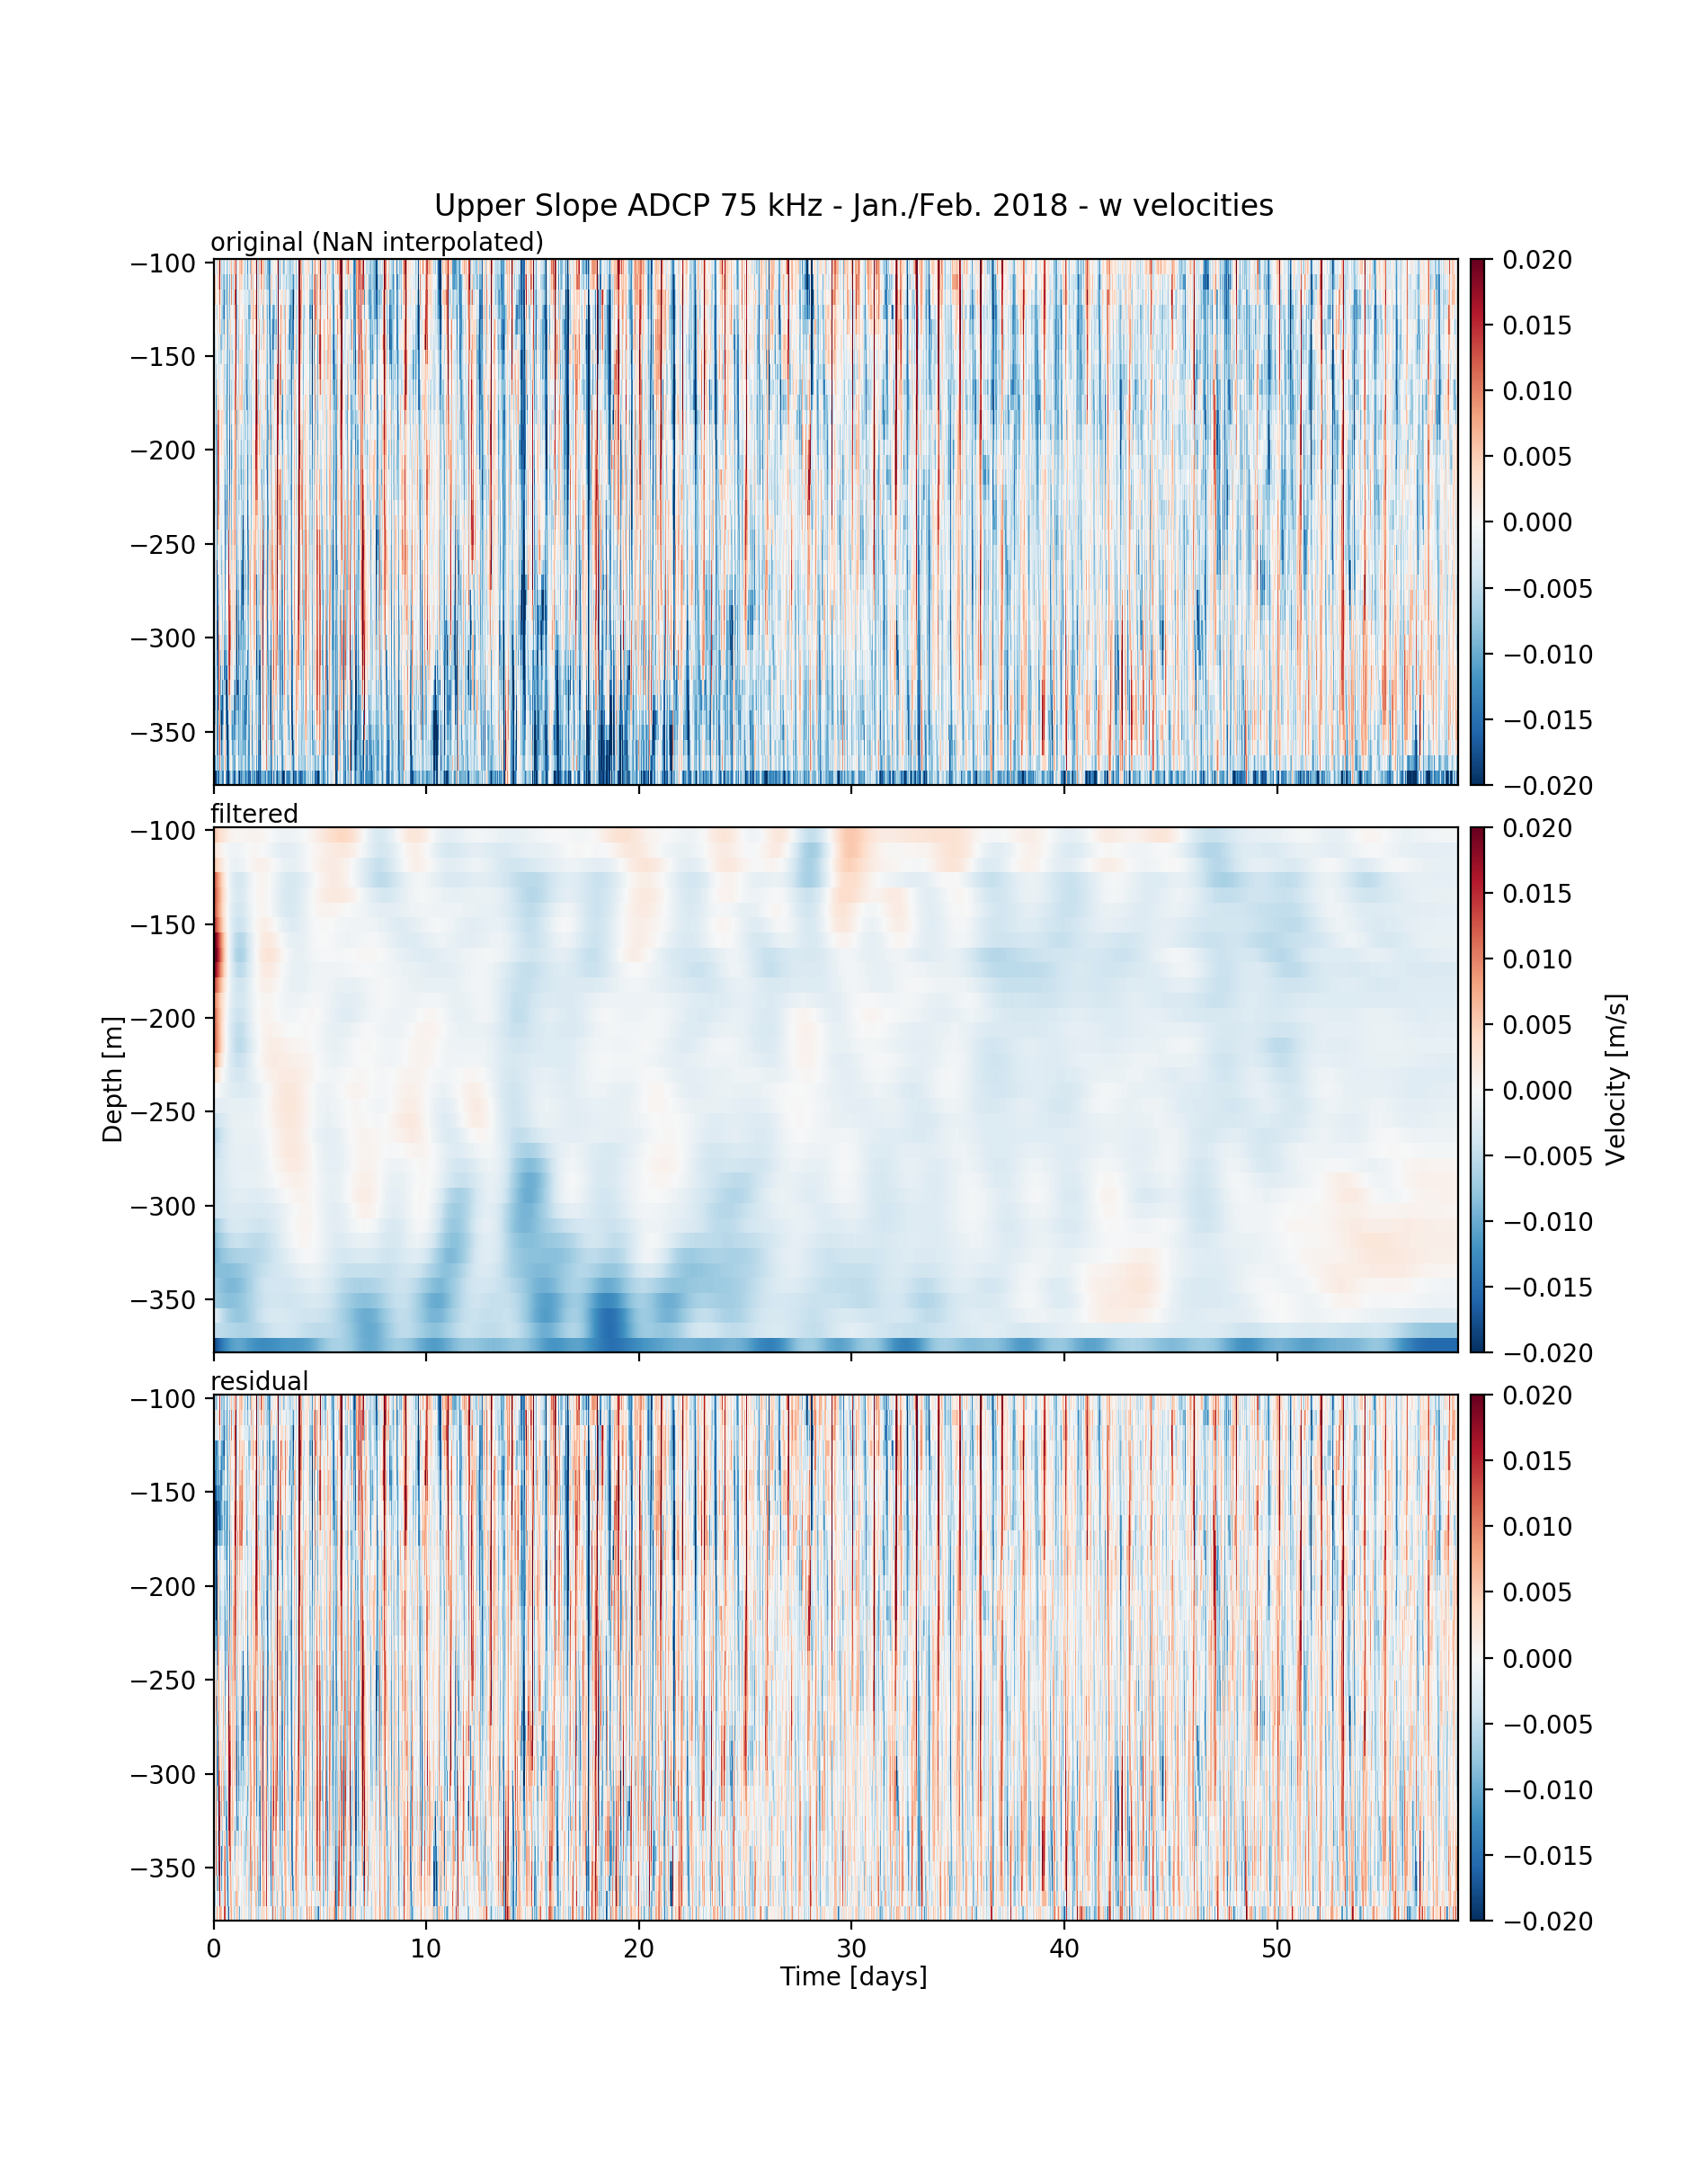

In [11]:
# plot w data

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.08)
fig.text(0.5, 0.9, 'Upper Slope ADCP 75 kHz - Jan./Feb. 2018 - w velocities', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'original (NaN interpolated)', va='center')
fig.text(0.123, 0.622, 'filtered', va='center')
fig.text(0.123, 0.359, 'residual', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.08, 'Time [days]', ha='center')

im1 = ax1.pcolormesh(time, -depth, worig.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40)

im2 = ax2.pcolormesh(time, -depth, wlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=40)

im3 = ax3.pcolormesh(time, -depth, whp.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40)